# Capstone Project - Portland Trip Planner
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Analysis](#analysis)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## Introduction <a name='introduction'></a>

People enjoy traveling on their vacation. Exploring a new place during vacation is an interesting and exciting experience, nonetheless, planning the trip before setting off is quite different. It could be time consuming or even stressful when our life is busy.

This project aims at making planning a trip easier and streamlining the process. We will build a map showing attractions in different colors to distinguish popularity. Available restaurants around the attractions will also be marked on the map. By this way, we can quickly figure out what to see and where to eat at our destination on a map. As a result, we can be more efficient on making an itinerary.

## Data <a name='data'></a>

To excute the idea of this project, we need data of attractions and restaurants at a destination. We will take Portland, Oregon as the destination in this project. The data source of attractions will be Google travel website https://www.google.com/travel/things-to-do/see-all with entering 'Portland, Oregon.' The data of restaurants will be from FourSquare. Let's first import associated libraries and then start to clean the data of attractions.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import re  # regular expression

from geopy.geocoders import Nominatim  # module to convert an address into latitude and longitude values

import json
import requests # Library to handle HTTP requests
from pandas import json_normalize  # library to translform json file into a dataframe

from sklearn.cluster import KMeans # machine learning clustering package Kmeans
from sklearn.preprocessing import StandardScaler # preprocessing data: standardization

import matplotlib.pyplot as plt
import folium # map rendering library
%matplotlib inline

pd.set_option('display.max_rows', 100)

### Clean and extract data: attractions of Portland

I saved HTML code of the searching result of Portland Things-to-do from Google travel website into a text file. Let's open and read the file. We will use regular expression to extract names, ratings and the number of reviews from the file.

In [2]:
# Open and read Portland to-see file
with open('portland_attractions.rtf', 'r', encoding='utf-8') as f:
    tosee_html = f.read()

tosee_html

'{\\rtf1\\ansi\\ansicpg1252\\cocoartf1671\\cocoasubrtf600\n{\\fonttbl\\f0\\fswiss\\fcharset0 Helvetica;\\f1\\fnil\\fcharset134 HiraginoSansGB-W3;}\n{\\colortbl;\\red255\\green255\\blue255;\\red0\\green0\\blue0;\\red50\\green223\\blue19;\\red28\\green33\\blue255;\n\\red203\\green218\\blue32;\\red20\\green0\\blue255;\\red209\\green200\\blue24;\\red34\\green5\\blue208;\\red207\\green161\\blue39;\n\\red43\\green117\\blue255;\\red187\\green219\\blue27;}\n{\\*\\expandedcolortbl;;\\cssrgb\\c0\\c0\\c0;\\cssrgb\\c20000\\c87843\\c8627;\\cssrgb\\c15294\\c26275\\c100000;\n\\cssrgb\\c83137\\c87059\\c15686;\\cssrgb\\c11373\\c3529\\c100000;\\cssrgb\\c85490\\c81176\\c11373;\\cssrgb\\c18431\\c16863\\c85098;\\cssrgb\\c85098\\c68627\\c19608;\n\\cssrgb\\c21176\\c55294\\c100000;\\cssrgb\\c77647\\c87059\\c13333;}\n\\margl1440\\margr1440\\vieww26820\\viewh15060\\viewkind0\n\\deftab720\n\\pard\\pardeftab720\\partightenfactor0\n\n\\f0\\fs24 \\cf0 \\expnd0\\expndtw0\\kerning0\n<div class="kQb6Eb" role="list"><d

After reviewing the text file, the information we need can be pulled out by using regular expression with the pattern of beginning of 'YmWhbc' and ending of 'reviews.' We will save the strings we pulled out into a list and then start to extract the names, ratings and the number of reviews for each attraction.

In [3]:
# extracting the strings between 'YmWhbc' and 'reviews' from file.
# save the strings into a list.

patn_raw = re.compile(r'YmWhbc.+reviews')

raw_matches = patn_raw.finditer(tosee_html)
raw_list_1 = []
for m in raw_matches:
    raw_list_1.append(m.group(0))

raw_list_1 = [raw.strip('YmWhbc') for raw in raw_list_1]

# There are a few places without rating that messing up some of the extracting results. We'll use RE again to clean up those items.
raw_list = []
for raw in raw_list_1:
    m = re.search(r'YmWhbc.+reviews', raw)
    try:
        raw_list.append(m.group())
    except:
        raw_list.append(raw)
        
print('There are total {} places.'.format(len(raw_list)))
raw_list[:5]

There are total 93 places.


['"\\cf0 >\\cf6 Pittock Mansion\\cf0 </div></div><div class="tP34jb "><\\cf7 span class="ta47le"><span aria-label="4.6 stars from 4965 reviews',
 '\\cf0 ">\\cf10 Portland Japanese Garden\\cf0 </div></div><div class="tP34jb "><\\cf11 span class="ta47le"><span aria-label="4.5 stars from 4967 reviews',
 '">Lan Su Chinese Garden</div></div><div class="tP34jb "><span class="ta47le"><span aria-label="4.6 stars from 2488 reviews',
 '">OMSI</div></div><div class="tP34jb "><span class="ta47le"><span aria-label="4.5 stars from 6932 reviews',
 '">Oregon Zoo</div></div><div class="tP34jb "><span class="ta47le"><span aria-label="4.5 stars from 14743 reviews']

There are totally 93 strings pulled out from the file. Now we will extract names, ratings and the number of reviews from the string.

In [4]:
# Extract name of places and save them in a list
places = []
for raw in raw_list:
    m = re.search(r'[A-Z].+[a-zI](\\|<)', raw)
    try:
        places.append(m.group())
    except:
        places.append(str(raw)[0:100])
        
places[:9]

['Pittock Mansion\\',
 'Portland Japanese Garden\\',
 'Lan Su Chinese Garden<',
 'OMSI<',
 'Oregon Zoo<',
 'International Rose Test Garden<',
 'Portland Art Museum<',
 'Washington Park<',
 'Pioneer Courthouse Square<']

In [5]:
# Reviewing the place list, one item naming 'Waterfront Renaissance..' is abnormal. Let's fixed it.
tmp = [places.index(i) for i in places if 'Waterfront Renaissance' in i]
places[tmp[0]] = 'Waterfront Renaissance Trail Vancouver WA'

places = [i.strip('\\<') for i in places]
places = [i.strip('YmWhbc">') for i in places]
places[0:9]

['Pittock Mansion',
 'Portland Japanese Garden',
 'Lan Su Chinese Garden',
 'OMSI',
 'Oregon Zoo',
 'International Rose Test Garden',
 'Portland Art Museu',
 'ashington Park',
 'Pioneer Courthouse Square']

After examining the name of the places, I found many 'Museum' are missing the last letter 'm'. One of examples is 'Portland Art Museu'. Meanwhile, 'W' is missing from the beginning. One of examples is 'ashington Park'. Let's fix these problems.

In [6]:
# Fill in the missing 'm' for 'Museum'
tmp = [places.index(i) for i in places if re.search(r'Museu$', i)]
for i in tmp:
    places[i] = places[i] + 'm'
    

In [7]:
# Fill in the missing 'W' in the beginning
tmp = [places.index(i) for i in places if re.search(r'^[a-z]', i)]
for i in tmp:
    places[i] = 'W' + places[i]
places[:9]

['Pittock Mansion',
 'Portland Japanese Garden',
 'Lan Su Chinese Garden',
 'OMSI',
 'Oregon Zoo',
 'International Rose Test Garden',
 'Portland Art Museum',
 'Washington Park',
 'Pioneer Courthouse Square']

In [8]:
# A few erratic name errors are fixed here. 
places[9] = 'Governor Tom McCall Waterfront'
places[10] = 'Hoyt Arboretum'
places[42] = 'The Freakybuttrue Peculiarium'
places[54] = 'Rice Northwest Museum of Rocks and Minerals'
places[74] = 'The Old Church'

for i, p in enumerate(places):
    print(i, p)

0 Pittock Mansion
1 Portland Japanese Garden
2 Lan Su Chinese Garden
3 OMSI
4 Oregon Zoo
5 International Rose Test Garden
6 Portland Art Museum
7 Washington Park
8 Pioneer Courthouse Square
9 Governor Tom McCall Waterfront
10 Hoyt Arboretum
11 The Grotto
12 Oaks Amusement Park
13 Portland Saturday Market
14 Forest Park
15 Shanghai Tunnels/Portland Underground Tour
16 St. Johns Bridge
17 Portland Children's Museum
18 Crystal Springs Rhododendron Garden
19 World Forestry Center
20 Fort Vancouver National Historic Site | Visitor Center
21 South Waterfront Lower Tram Terminal
22 Mill Ends Park
23 Oregon Historical Society
24 Fort Vancouver National Historic Site
25 Tilikum Crossing Bridge
26 Tryon Creek State Natural Area
27 Powell's City of Books
28 Portland Audubon
29 Mt Tabor Park
30 Powell Butte
31 Peninsula Park
32 Laurelhurst Park
33 Witch's Castle
34 Wildwood Trail
35 Tryon Creek
36 Eastbank Esplanade
37 Keller Fountain Park
38 Leach Botanical Garden
39 Council Crest Park
40 Oaks Bo

The name of attractions are intact now. Next we will extract ratings and the number of reviews from the strings.

In [9]:
# Extract rating from raw_list
rating = []
for rate in raw_list:
    m = re.search(r'\d[.|\s]\d?\s?stars', rate)
    try:
        rating.append(m.group())
    except:
        rating.append(rate)
        
rating = [float(i.strip('stars')) for i in rating]
rating[:10]

[4.6, 4.5, 4.6, 4.5, 4.5, 4.7, 4.7, 4.7, 4.4, 4.5]

In [10]:
# Extract the number of reviews from raw_list
reviews = []

for raw in raw_list:
    m = re.search(r'\d+\s(review)', raw)
    try:
        reviews.append(m.group())
    except:
        reviews.append(raw)

reviews = [int(i.strip('review')) for i in reviews]
reviews[:10]

[4965, 4967, 2488, 6932, 14743, 4753, 3964, 9618, 6062, 6210]

Now that we have names, rating and the number of reviews in hand, we will put these data together into a dataframe.

In [11]:
# Create a dataframe for name, rating and the number of reviews of Portland attractions.
tosee_df = pd.DataFrame(list(zip(places, rating, reviews)), columns = ['place', 'rating', 'reviews'])
tosee_df.head()

,place,rating,reviews
0,Pittock Mansion,4.6,4965
1,Portland Japanese Garden,4.5,4967
2,Lan Su Chinese Garden,4.6,2488
3,OMSI,4.5,6932
4,Oregon Zoo,4.5,14743


In [12]:
# examine descriptive statistics number
tosee_df.describe()

,rating,reviews
count,93.000000,93.000000
mean,4.532258,1721.946237
std,0.292352,3336.139947
min,2.800000,1.000000
25%,4.400000,173.000000
50%,4.600000,598.000000
75%,4.700000,1650.000000
max,5.000000,24920.000000


From the descriptive statistics number showed above, the range of the number of reviews is wide, from 1 to 24920. The mean is 1721 and the standard deviation is 3336. The first quartile is 173, the median is 598 and the third quartile is 1650. Comparing the first quartil 173 with mean 1721, or median 598, it is relatvely small. That means the places gain limited attention. we will remove the places having reviews less than 173, the first quartile.

In [13]:
# Remove the places having less than 173 reviews.
tosee_df = tosee_df[tosee_df['reviews'] > 173]
tosee_df.reset_index(drop=True, inplace=True)
# check how many places we have now
tosee_df.shape

(69, 3)

Now we have 69 attractions. We will use geopy to look for geographical coordinates for each place. We will need the coordinates to look for nearby restaurnats in FourSquare later.

In [14]:
# use geopy to find latitude & longitude
geolocator = Nominatim(user_agent='portland_agent')

for i, place in enumerate(tosee_df['place']):
    # a few places are actually located in Vancouver, WA. They are so closed to Portland that they are inclued in Portland attractions.
    if 'Vancouver' in place:
        to_find = place + ', Vancouver, WA'
    else:
        to_find = place + ', Portland, Oregon'
    
    location = geolocator.geocode(to_find)
    try:
        tosee_df.loc[i, 'latitude'] = location.latitude
        tosee_df.loc[i, 'longitude'] = location.longitude
    except:
        tosee_df.loc[i, 'latitude'] = to_find
        tosee_df.loc[i, 'longitude'] = to_find
        
# A few places that are close to Portland, but are not located in Porland city. We will try only use 'Oregon' to find their geographical coordiantes.
for i, place in enumerate(tosee_df['place']):
    if tosee_df.loc[i, 'latitude'] == tosee_df.loc[i, 'longitude']:
        to_find = place + ', Oregon'
        location = geolocator.geocode(to_find)
        if location:
            tosee_df.loc[i, 'latitude'] = location.latitude
            tosee_df.loc[i, 'longitude'] = location.longitude

tosee_df.head()

,place,rating,reviews,latitude,longitude
0,Pittock Mansion,4.6,4965,45.5252,-122.716
1,Portland Japanese Garden,4.5,4967,45.5187,-122.708
2,Lan Su Chinese Garden,4.6,2488,45.5257,-122.673
3,OMSI,4.5,6932,45.5083,-122.666
4,Oregon Zoo,4.5,14743,45.5098,-122.713


In [15]:
# save file as csv file for backup
tosee_df.to_csv('portland_tosee_geocor', index=False)

In [16]:
# Review the places that failed to find latitude and longitude
no_ll = tosee_df[tosee_df['latitude'] == tosee_df['longitude']]
no_ll

,place,rating,reviews,latitude,longitude
15,Shanghai Tunnels/Portland Underground Tour,3.7,324,"Shanghai Tunnels/Portland Underground Tour, Po...","Shanghai Tunnels/Portland Underground Tour, Po..."
37,Pearson Air Museum,4.6,248,"Pearson Air Museum, Portland, Oregon","Pearson Air Museum, Portland, Oregon"
38,The Freakybuttrue Peculiarium,4.2,1008,"The Freakybuttrue Peculiarium, Portland, Oregon","The Freakybuttrue Peculiarium, Portland, Oregon"
46,Roloff Farms,4.6,682,"Roloff Farms, Portland, Oregon","Roloff Farms, Portland, Oregon"
56,Bella Organic Far,4.0,261,"Bella Organic Far, Portland, Oregon","Bella Organic Far, Portland, Oregon"
60,Elk Rock Garden,4.8,223,"Elk Rock Garden, Portland, Oregon","Elk Rock Garden, Portland, Oregon"
68,Frenchman's Bar Regional Park,4.6,312,"Frenchman's Bar Regional Park, Portland, Oregon","Frenchman's Bar Regional Park, Portland, Oregon"


There are 7 places failed to find geographical coordinates. The number of reviews of these 7 places are not high. We will ignore them and drop them from dataframe.

In [17]:
# Drop the rows with latitude and longitude
tosee_df.drop(no_ll.index.tolist(), inplace=True)
tosee_df.reset_index(drop=True, inplace=True)
tosee_df.shape

(62, 5)

### Clean and extract data: nearby restaurants

We finalized Portland to-see list which includes 62 places. Now we will start to use FourSquare API to find nearby restaurants around these places. Let's get API credential ready first.

In [19]:
# Extract credential from a josn file
api_cred = json.load(open("fourSquareCredential.json"))
CLIENT_ID = api_cred['CLIENT_ID']
CLIENT_SECRET = api_cred['CLIENT_SECRET']
VERSION = api_cred['VERSION']
LIMIT = 30

print('FourSquare credential is ready.')

FourSquare credential is ready.


In [20]:
# define a function that will search FourSquare for close-by restaurants

def search_by_category(df, latitude, longitude, search_query, radius):
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
    result = requests.get(url).json()
    venues = result['response']['venues']
    df = df.append(json_normalize(venues), ignore_index = True)
    return df

In [21]:
# use function search_by_category to look for close-by( in 1000 meters) restaurants and put them into dataframe
raw_restaurant = pd.DataFrame()
search_query = 'restaurant'
radius = 1000
for lat, long in zip(tosee_df['latitude'], tosee_df['longitude']):
    raw_restaurant = search_by_category(raw_restaurant, lat, long, search_query, radius)

raw_restaurant.shape

(664, 25)

In [22]:
# save FourSquare restaurants data as csv file for backup
raw_restaurant.to_csv('close_by_restaurant', index=False)

In [23]:
raw_restaurant.head()

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,...,location.formattedAddress,delivery.id,delivery.url,delivery.provider.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.icon.name,location.crossStreet,venuePage.id,location.neighborhood
0,55c6d381498e9a5c8f034964,Khao Soy Thai Restaurant,"[{'id': '4bf58dd8d48988d149941735', 'name': 'T...",v-1605316695,False,2340 NW Westover Rd,45.524726,-122.699428,"[{'label': 'display', 'lat': 45.52472628473559...",946,...,"[2340 NW Westover Rd, Portland, OR 97210, Unit...",549017,https://www.grubhub.com/restaurant/khao-soy-th...,grubhub,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_grubhub_20180129.png,NaN,NaN,NaN
1,5be4088b625a66002cf315fe,Thai Bloom! Portland: Restaurant and Catering,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",v-1605316695,False,333 NW 23rd Ave,45.525288,-122.698662,"[{'label': 'display', 'lat': 45.52528762817383...",1033,...,"[333 NW 23rd Ave, Portland, OR 97210, United S...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,510dd94be4b01d20ece508a7,수라 Korean Restaurant,"[{'id': '4bf58dd8d48988d113941735', 'name': 'K...",v-1605316695,False,NaN,45.525406,-122.698562,"[{'label': 'display', 'lat': 45.525406, 'lng':...",1047,...,"[Portland, OR 97210, United States]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4aa30efaf964a5202c4320e3,August Moon Chinese,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",v-1605316695,False,405 NW 23rd Ave,45.525643,-122.698497,"[{'label': 'display', 'lat': 45.52564257632973...",1070,...,"[405 NW 23rd Ave (NW Flanders), Portland, OR 9...",77353,https://www.grubhub.com/restaurant/august-moon...,grubhub,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_grubhub_20180129.png,NW Flanders,NaN,NaN
4,4ad781f6f964a520950b21e3,Chen's Good Taste Restaurant,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",v-1605316696,False,18 NW 4th Ave,45.523531,-122.674297,"[{'label': 'display', 'lat': 45.52353088512034...",261,...,"[18 NW 4th Ave (btw W Burnside & NW Couch), Po...",NaN,NaN,NaN,NaN,NaN,NaN,btw W Burnside & NW Couch,NaN,NaN


There are some columns of restaurant data that we get from FourSquare are not needed. We will only keep columns of name, categories, location coordinates and id. Next we will extract only the name from the column of categories.

In [24]:
# keep only columns of name and categories
filtered_columns = ['name', 'categories', 'location.lat', 'location.lng', 'id']
df_restaurant = raw_restaurant.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
df_restaurant['categories'] = df_restaurant.apply(get_category_type, axis=1)
# clean column names by keeping only last term
df_restaurant.columns = [column.split('.')[-1] for column in df_restaurant.columns]

df_restaurant.head()

,name,categories,lat,lng,id
0,Khao Soy Thai Restaurant,Thai Restaurant,45.524726,-122.699428,55c6d381498e9a5c8f034964
1,Thai Bloom! Portland: Restaurant and Catering,Restaurant,45.525288,-122.698662,5be4088b625a66002cf315fe
2,수라 Korean Restaurant,Korean Restaurant,45.525406,-122.698562,510dd94be4b01d20ece508a7
3,August Moon Chinese,Chinese Restaurant,45.525643,-122.698497,4aa30efaf964a5202c4320e3
4,Chen's Good Taste Restaurant,Chinese Restaurant,45.523531,-122.674297,4ad781f6f964a520950b21e3


In [25]:
df_restaurant.shape

(664, 5)

Data of attractions and nearby restaurants are ready. We have 62 attractions and 664 nearby restaurants.

## Analysis <a name='analysis'></a>

In contrast with the wide range of the number of reviews, the range of ratings for attractions are narrow, between 4.3 and 4.9. From the scatter plot below, we can find that different places would have the same rating, but the the number of reviews they got may have a big discrepancy. 

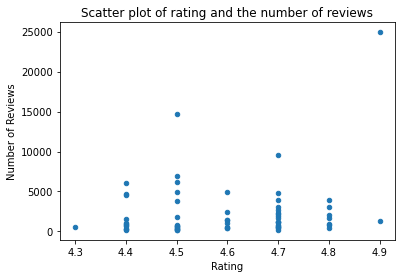

In [26]:
tosee_df.plot(kind='scatter', x='rating', y='reviews');
plt.title('Scatter plot of rating and the number of reviews');
plt.xlabel('Rating');
plt.ylabel('Number of Reviews');

### K-Means Cluster

We will use K-Means cluster method to combine rating and the number of reviews into a label of popularity. Let's standardize the data and then cluster the attractions into 5 popularities.

In [103]:
# slice columns of rating and reviews for clustering
X_rating = tosee_df[['rating', 'reviews']].to_numpy()
# standardization
std_data = StandardScaler().fit_transform(X_rating)

In [104]:
# K-Means clustering
k = 5
k_means = KMeans(init="k-means++", n_clusters=k, n_init=12)
k_means.fit(std_data)

KMeans(n_clusters=5, n_init=12)

In [105]:
popularity_label = k_means.labels_
popularity_label

array([4, 4, 1, 4, 3, 1, 1, 3, 4, 4, 1, 1, 4, 4, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0, 1, 1, 1, 4, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0], dtype=int32)

In [106]:
# add labels of popularity into dataframe
tosee_df.loc[:, 'popularity'] = popularity_label.tolist()
tosee_df.head()

,place,rating,reviews,latitude,longitude,popularity
0,Pittock Mansion,4.6,4965,45.5252,-122.716,4
1,Portland Japanese Garden,4.5,4967,45.5187,-122.708,4
2,Lan Su Chinese Garden,4.6,2488,45.5257,-122.673,1
3,OMSI,4.5,6932,45.5083,-122.666,4
4,Oregon Zoo,4.5,14743,45.5098,-122.713,3


### Review clustering labels

Let's see the distribution of labels of popularity.

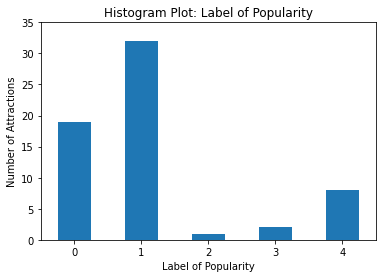

In [121]:
ax = plt.subplot()
plt.hist(tosee_df['popularity'], range=(-0.25, 4.75))
plt.xlabel('Label of Popularity');
plt.ylabel('Number of Attractions');
plt.title('Histogram Plot: Label of Popularity');
plt.axis([-.5, 4.5, 0, 35])
ax.set_xticks([0, 1, 2, 3, 4]);

More than 30 attractions fall in label 1 which is highest. The second high is label 0, a little lower than 20. Next let's see the scatter plot between labels of popularit and ratings.

/Users/claire/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


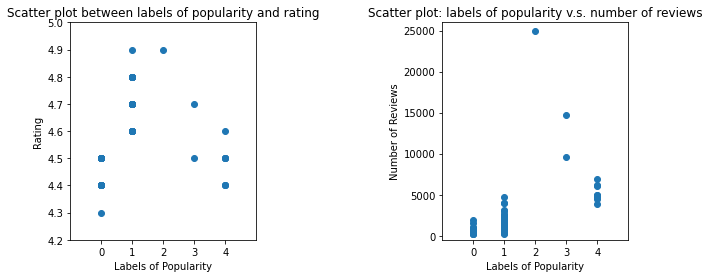

In [102]:
plt.figure(figsize=[10, 4]);
ax_1 = plt.subplot(1, 2, 1);
x = tosee_df['popularity'];
y_rating = tosee_df['rating'];
y_reviews = tosee_df['reviews'];
plt.plot(x, y_rating, 'o');
plt.title('Scatter plot between labels of popularity and rating');
plt.xlabel('Labels of Popularity');
plt.ylabel('Rating');
plt.axis([-1, 5, 4.2, 5]);
ax_1.set_xticks([0, 1, 2, 3, 4]);

ax_2 = plt.subplot(1, 2, 2);
plt.subplot(1, 2, 2);
plt.plot(x, y_reviews, 'o');
plt.title('Scatter plot: labels of popularity v.s. number of reviews');
plt.xlabel('Labels of Popularity');
plt.ylabel('Number of Reviews');
plt.axis([-1, 5, -500, 26000]);
ax_2.set_xticks([0, 1, 2, 3, 4]);

plt.subplots_adjust(wspace=1);

Let's see scatter plot between labels of popularity and the number of reviews.

From the two scatter plots above, we can draw the conclusions:
Label 0: Low rating and low number of reviews.
Label 1: Higher rating but lower number of reviews.
Label 2: Very high rating and very high number of reviews.
Label 3: Average rating but very high number of reviews.
Label 4: Lower rating but higher number of reviews.

### Folium map

Now we will put both attractions and restaurants on a map. Let's start by creating a folium map centering at Portland, Oregon.

In [104]:
# Getting latitude and longitude of Portland
destination = 'Portland, Oregon'

destination_ll = geolocator.geocode(destination)
destination_lat = destination_ll.latitude
destination_long = destination_ll.longitude
print('The geographical coordinate of {} are: {}, {}'.format(destination, destination_lat, destination_long))

The geographical coordinate of Portland, Oregon are: 45.5202471, -122.6741949


The markers of attractions are in different colors for distinguishing popularity. **Label 0 is light gray. Label 1 is dark blue. Label 2 is red. Label 3 is orange. label 4 is light blue.**

In [106]:
# create map of Portland using latitude and longitude values
map_portland = folium.Map(location=[destination_lat, destination_long], zoom_start=11)
# markers of attractions added to map
popularity_color = ['lightgray', 'darkblue', 'red', 'orange', 'lightblue']
for lat, long, att, rating, review, popularity in zip(tosee_df['latitude'], tosee_df['longitude'], tosee_df['place'], tosee_df['rating'], tosee_df['reviews'], tosee_df['popularity']):
    label = att + ' ' + str(rating) + '( ' + str(review) + ' )'
    label = folium.Popup(label, parse_html=True)   
    folium.Marker(
    [lat, long],
    popup=label,
    icon=folium.Icon(color=popularity_color[popularity])
    ).add_to(map_portland)

map_portland

Purple circles are nearby restaurants.

In [107]:
# put restaurants on map
for lat, lng, name, category in zip(df_restaurant['lat'], df_restaurant['lng'], df_restaurant['name'], df_restaurant['categories']):
    label = name + ((', ' + category) if category!=None else '')
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'purple',
        fill_color = 'purple',
        fill_opacity = 0.3,
        fill = True,
        parse_html=False).add_to(map_portland)

map_portland

## Discussion <a name='discussion'> </a>

According to the labels of popularity generated by K-Means cluster, label 2 is the most popular attraction. It gets the highest rating and highest number of reviews. We have only one attraction belonging to this label, which is Powell’s city of books. Powell’s city of books is Portland’s icon and it is really one of a kind. I think it deserves the highest mark.

Attractions of label 0 are low rating and low number of reviews. There are 19 attractions belonging to this label. If you want to skip some of the attractions, obviously label 0 is the first group to be removed.

Label 3 has good ratings and  high number of reviews, I would consider this group as the second best attraction to visit. There are two attractions belonging to label 3. 

I think it is hard to choose between label 1 and label 4. Label 1 has higher rating but lower number of reviews while label 4 has lower rating but higher number of reviews. I think attractions in these two groups are not dominating places when planning an itinerary. You can add attractions of label 1 and 4 into your itinerary when they are nearby or close to your route.


## Conclusion <a name='conclusion'></a>

I think labels of popularity generated by K-Means cluster do help to pick attractions from a long list. Besides it identifies an outstanding attraction like Powell’s city of books, it makes us confidently remove the attractions belonging to label 0. By skipping label 0, the attractions list is shortened by 30%, from 62 attractions to 43 attractions. It definitely is easier to make choices from a shorter list.

A map showing both attractions and nearby restaurants indeed solves three essential questions when planning a trip. To-see, to-eat and geographical locations are integrated on a map. I think this is really neat!